# General SIR ODE model

The general SIR ODE model is a system of three differential equations for the population of size $n$, divided into three subpopulations $S$ (susceptible), $I$ (infectious) and $R$ (removed), parametrised by the following equations:

$$ \frac{dS}{dt} = - \frac{\beta S I}{n} $$

$$ \frac{dI}{dt} = \frac{\beta S I}{n} - \gamma I $$

$$ \frac{dR}{dt} = \gamma I $$

It follows further from the assumption of static demographics that

$$ S + I + R = n $$

and

$$ \frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0 $$

In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
N = 1000
I_0 = 1.0
R_0 = 0.0
S_0 = N - I_0 - R_0
R0 = 2.67
gamma = 1.0/18
beta = R0 * gamma
t = np.linspace(0, 160, 160)

In [3]:
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    Sdot = - beta * S * I / N 
    Idot = (beta * S * I) / N - gamma * I
    Rdot = gamma * I
    return Sdot, Idot, Rdot

In [4]:
def solve_sir(gamma, R0, N = 1e4, I_0 = 0.01*N, t_days = 90):
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0 * gamma
    t = np.linspace(0, t_days, t_days)
    
    y_0 = S_0, I_0, R_0
    
    res = odeint(sir_model, y_0, t, args=(N, beta, gamma)).T
    return res[0], res[1], res[2], t

In [5]:
def plot_single_sir(S, I, R, t, inverse_gamma, R0):
    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
    ax.plot(t, S, "b", alpha=0.5, lw=2, label="Susceptible")
    ax.plot(t, I, "r", alpha=0.5, lw=2, label="Infected")
    ax.plot(t, R, "g", alpha=0.5, lw=2, label="Removed")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Subpopulation size")
    ax.text(0, 7000, "$R_0$: 2.63", fontsize=12)
    ax.text(0, 6000, "$\gamma$: 1/18", fontsize=12)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which="major", c="w", lw=2, ls="-")
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)
    plt.show()

In [6]:
def create_plot_grid(R0_min=1.5, R0_max=6.5, R0_steps=5, inv_gamma_min=8.5-3.9, inv_gamma_max=8.5+3.9, inv_gamma_steps=5, days=90, save=True):
    fig = plt.figure(figsize = (14, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    R0_space = np.linspace(R0_min, R0_max, R0_steps)
    gamma_space = np.linspace(inv_gamma_min, inv_gamma_max, inv_gamma_steps)

    for idxx, valx in enumerate(R0_space):
        for idxy, valy in enumerate(gamma_space):
            R0 = valx
            gamma = 1.0/valy
            S, I, R, t = solve_sir(gamma, R0, t_days=days)
            ax = fig.add_subplot(5, 5, idxx*5 + (idxy+1))
            ax.plot(t, S, "b", alpha=0.5, lw=2, label="Susceptible")
            ax.plot(t, I, "r", alpha=0.5, lw=2, label="Infected")
            ax.plot(t, R, "g", alpha=0.5, lw=2, label="Removed")
            plot_label = "$R_0$: " + str(valx) + ", " + "$\gamma^{-1}$: " + str(valy)
            ax.set_title(plot_label)
            ax.yaxis.set_tick_params(length=0)
            ax.xaxis.set_tick_params(length=0)
            ax.grid(b=True, which="major", c="w", lw=2, ls="-")
            #legend = ax.legend()
            #legend.get_frame().set_alpha(0.5)
            for spine in ("top", "right", "bottom", "left"):
                ax.spines[spine].set_visible(False)
            ax.set_xlabel("Time (days)")
            ax.set_ylabel("Subpopulation size")


    if save:
        plt.savefig("../paper/figures/fig1-odes.pdf")
    
    plt.show()

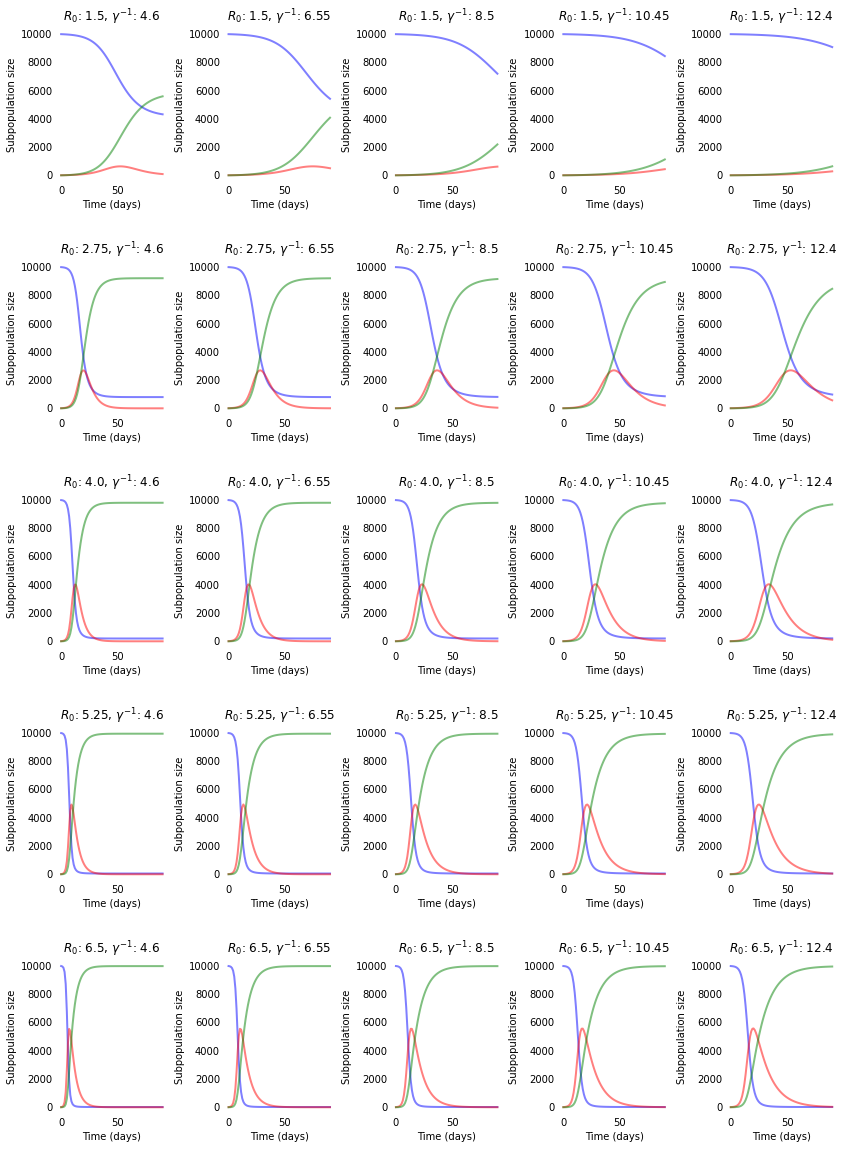

In [7]:
create_plot_grid()

# Strategy diagrams based on social distancing

Let $\bar{\sigma}(P)$ denote the average engagement (in the terms of Reluga (2010), the 'investment') of the population $P$, with $0 \leq \bar{\sigma}(P) \leq 1$, where $1$ stands for a strategy of pure and perfect adherence to social distancing and $0$ stands for no adherence at all. Then, given $R_0$ and $\gamma$, we can conceptualise and calculate outcomes, in dependence on the compliance factor $\delta$ ($\frac{p_d}{n}$, where $p_d$ are those members of $P$ that are engaged in social distancing).

In [8]:
def sir_strategy_model(y, t, N, delta, beta, gamma):
    S, I, R = y
    Sdot = - (1-delta) * beta * S * I / N 
    Idot = (1-delta) * (beta * S * I) / N - gamma * I
    Rdot = gamma * I
    return Sdot, Idot, Rdot

In [9]:
@np.vectorize
def solve_strategy_for_cumulative_infected(delta, R0, days=14, N = 1e4, I_0 = 0.01*N, gamma=1.0/8.5):
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0 * gamma
    t = np.linspace(0, days, days)

    y_0 = S_0, I_0, R_0

    res = odeint(sir_strategy_model, y_0, t, args=(N, delta, beta, gamma)).T
    return max(res[1])

In [10]:
def plot_contours_for_days(sigma_min=0, sigma_max=1, R0_min=1.5, R0_max=6.5, days=[14, 21, 28, 35], save=True):
        
    R0_space = np.linspace(R0_min, R0_max, 100)
    sigma_space = np.linspace(sigma_min, sigma_max, 100)
    
    fig = plt.figure(figsize = (15, 4))
    fig.subplots_adjust(wspace=0.5)
    
    for idx, val in enumerate(days):
        z = solve_strategy_for_cumulative_infected(sigma_space[:, None], R0_space[None, :], val)
        ax = fig.add_subplot(1, len(days), idx + 1)
        contours = ax.contour(R0_space, sigma_space, z, cmap="viridis", levels = [100, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000])
        ax.clabel(contours, inline=True, fontsize = 8, fmt="%1.f")
        ax.set_title(f"{val} days")
        ax.set_xlabel(r"$R_0$")
        ax.set_ylabel(r"$\delta(P)$")
        
    if save:
        plt.savefig("../paper/figures/fig2-strategy_solutions_by_days.pdf")

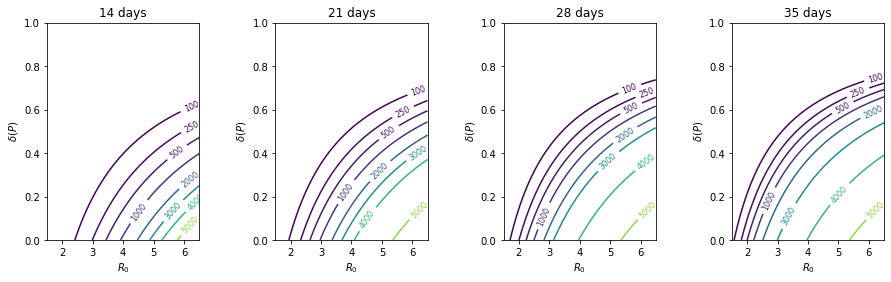

In [11]:
plot_contours_for_days()

# Individual risk as a function of social response

Equation (12) and (13) give us a quantification of risk at time $t$ given the separation $\bar{\delta}(P)$, $R_0$, $\gamma$ and population size $n$, so that

$$ f_r(\bar{\delta}(P), t) = \frac{\bar{\delta}(P) R_0 \gamma I(t)}{n^2} $$

For a population of $n = 10,000$ and $\gamma = 1/8.5$, the risk $f_r$ can be calculated as a function of $t$ and $\delta(P)$.

In [49]:
def risk_model(y, t, N, delta, beta, gamma, R0):
    S, I, R, r = y
    Sdot = - (1-delta) * beta * S * I / N 
    Idot = (1-delta) * (beta * S * I) / N - gamma * I
    Rdot = gamma * I
    r = (delta * R0 * gamma * I)/N**2
    return Sdot, Idot, Rdot, r

In [50]:
@np.vectorize
def solve_strategy_for_risk(delta, R0, days=14, N = 1e4, I_0 = 0.01*N, gamma=1.0/8.5):
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0 * gamma
    t = np.linspace(0, days, days)
    risk_0 = 0.0
    
    y_0 = S_0, I_0, R_0, risk_0

    res = odeint(risk_model, y_0, t, args=(N, delta, beta, gamma, R0)).T
    return res[3][-1]

In [51]:
def plot_risk_at_days(sigma_min=0, sigma_max=1, R0_min=1.5, R0_max=6.5, days=[14, 21, 28, 35], save=True):
    R0_space = np.linspace(R0_min, R0_max, 100)
    sigma_space = np.linspace(sigma_min, sigma_max, 100)
    
    fig = plt.figure(figsize = (15, 4))
    fig.subplots_adjust(wspace=0.5)
    
    for idx, val in enumerate(days):
        z = solve_strategy_for_risk(sigma_space[:, None], R0_space[None, :], days=val)
        z /= (z.max()/1.0)
        ax = fig.add_subplot(1, len(days), idx + 1)
        contours = ax.contour(R0_space, sigma_space, z, cmap="viridis")
        ax.clabel(contours, inline=True, fontsize = 8, fmt="%.2f")
        ax.set_title(f"{val} days")
        ax.set_xlabel(r"$R_0$")
        ax.set_ylabel(r"$\delta(P)$")
        
    if save:
        plt.savefig("../paper/figures/fig3-risk-of-adherence.pdf")

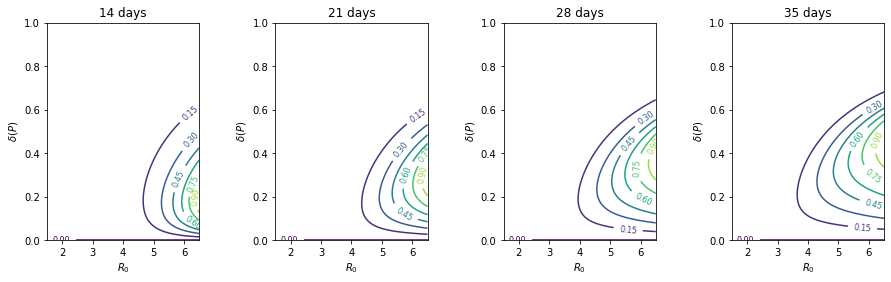

In [52]:
plot_risk_at_days()

## Cost of sickness vs cost of avoidance equilibria

For cost of distancing $c_d$ and cost of $f_r(\bar{\delta}(P), t) c_s$ for a population $P$, an equilibrium exists so that 

$$ c_d = f_r(\bar{\delta}(P), t) c_s $$

and hence

$$ c_d = c_s \frac{\bar{\delta}(P) R_0 \gamma I(t)}{n^2} $$

which yields the fraction $\frac{c_s}{c_d}$, describing how much more cost is incurred by sickness than by distancing at the given time $t$ and the current distancing adherence $\bar{\delta}(P)$.

In [176]:
def plot_cost_ratio_for_days(days = [7, 14, 21, 28, 35], save=True):
    delta_space = np.linspace(0, 1, 100)

    fig = plt.figure(figsize = (8, 10))
    
    for idx, val in enumerate(days):
        cs_over_cd = (1e4 ** 2)/(delta_space * 2.67 * 1.0/8.5 * get_I_t(delta_space, days=val))
        plt.plot(delta_space, cs_over_cd, alpha=0.5, lw=2, label=f"{val} days")
        

    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)
    plt.ylabel(r"Factor of $c_s$")
    plt.xlabel(r"$\delta(P)$")
        
    if save:
        plt.savefig("../paper/figures/fig4-cs_cd")

/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


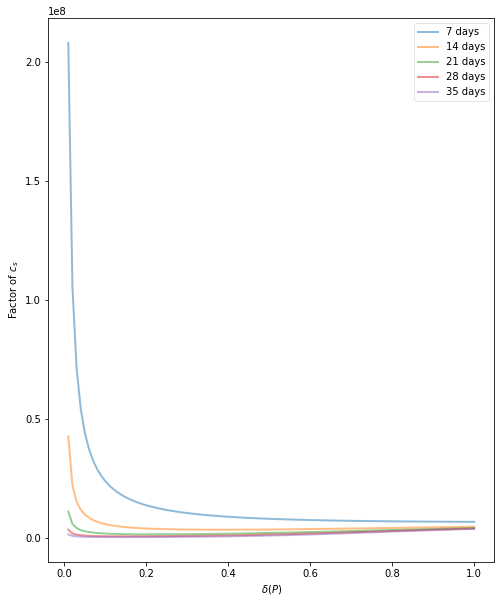

In [178]:
plot_cost_ratio_for_days()